In [30]:
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import rasterio
import seaborn as sns
from matplotlib import pyplot as plt
from rasterio.plot import show


# Calculate one year ago from today's date
one_year_ago = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")

# Modify the SQL query
guncrime_sql_query = "SELECT text_general_code, dispatch_date, point_x, point_y FROM incidents_part1_part2 WHERE dispatch_date_time >= '{}' AND text_general_code IN ('Aggravated Assault Firearm', 'Robbery Firearm')".format(one_year_ago)

# Make the GET request
guncrime_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": guncrime_sql_query})

# Get the data
guncrime_data = guncrime_response.json()["rows"]

# convert guncrime_data to a pandas dataframe
guncrime_df = pd.DataFrame(guncrime_data)

# drop null geometry values
guncrime_df = guncrime_df[guncrime_df['point_x'].notnull()]
guncrime_df = guncrime_df[guncrime_df['point_y'].notnull()]

# Convert the data to a geopandas dataframe
guncrime_gdf = gpd.GeoDataFrame(guncrime_df, geometry=gpd.points_from_xy(guncrime_df.point_x, guncrime_df.point_y), crs='EPSG:4326')

# drop the lat and lon columns
guncrime_gdf.drop(['point_x', 'point_y'], axis=1, inplace=True)

# convert the geometry column to a CRS 2272
guncrime_gdf.to_crs(epsg=2272, inplace=True)

In [31]:
guncrime_gdf.head(10)

,text_general_code,dispatch_date,geometry
0,Aggravated Assault Firearm,2023-03-11,POINT (2701499.991 254527.321)
1,Aggravated Assault Firearm,2023-02-26,POINT (2687640.511 228770.118)
2,Aggravated Assault Firearm,2023-02-26,POINT (2713880.884 277084.477)
3,Aggravated Assault Firearm,2023-03-11,POINT (2693641.638 272700.071)
4,Robbery Firearm,2023-02-22,POINT (2686795.954 250843.724)
5,Robbery Firearm,2023-03-11,POINT (2681170.845 236628.713)
6,Robbery Firearm,2023-03-11,POINT (2676496.977 229785.953)
7,Robbery Firearm,2023-02-19,POINT (2721451.249 271406.647)
8,Robbery Firearm,2023-02-19,POINT (2688093.833 243491.353)
9,Robbery Firearm,2023-02-26,POINT (2700716.635 258604.904)


In [32]:
# check if guncrime_data contains empty geometry values
guncrime_gdf.isnull().sum()

text_general_code    0
dispatch_date        0
geometry             0
dtype: int64

<Axes: >

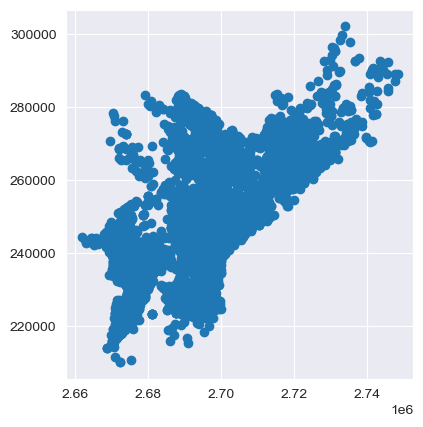

In [27]:
guncrime_gdf.plot()

In [33]:
from scipy.stats import gaussian_kde

# Get X and Y coordinates of well points
x_sk = guncrime_gdf["geometry"].x

In [34]:
y_sk = guncrime_gdf["geometry"].y

In [35]:
# drop null values
x_sk = x_sk.dropna()
y_sk = y_sk.dropna()

In [36]:
# Get minimum and maximum coordinate values of well points
min_x_sk, min_y_sk, max_x_sk, max_y_sk = guncrime_gdf.total_bounds

# Create a cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk, YY_sk = np.mgrid[min_x_sk:max_x_sk:100j, min_y_sk:max_y_sk:100j]

In [37]:
# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk = np.vstack([XX_sk.ravel(), YY_sk.ravel()])

# Create 2-D array of the coordinate values of the well points
Xtrain_sk = np.vstack([x_sk, y_sk])

# Estimate the bandwidth using Silverman's rule, which is more robust than Scott's
kde_sk = gaussian_kde(Xtrain_sk, bw_method='silverman')

# Evaluate the estimator on coordinate pairs
Z_sk = kde_sk(positions_sk)

# Reshape the data to fit mesh grid
Z_sk = Z_sk.reshape(XX_sk.shape)

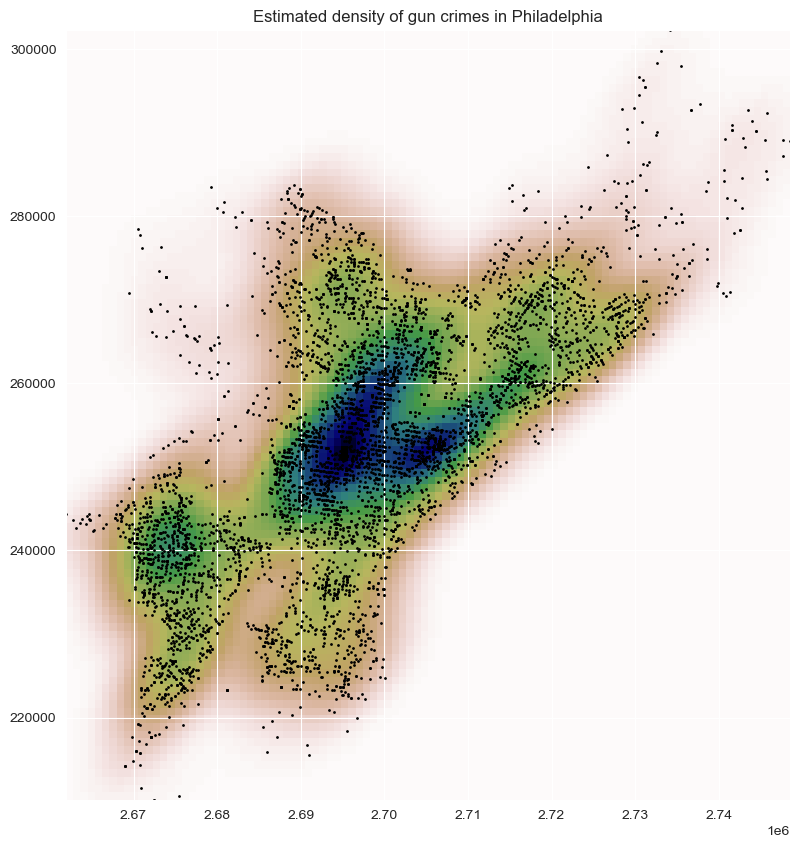

In [39]:
# plot Z_sk
plt.figure(figsize=(10,10))
plt.imshow(np.rot90(Z_sk), cmap=plt.cm.gist_earth_r, extent=[min_x_sk, max_x_sk, min_y_sk, max_y_sk])
plt.plot(x_sk, y_sk, 'k.', markersize=2)
plt.title('Estimated density of gun crimes in Philadelphia')
plt.show()

In [40]:
today = datetime.datetime.today().strftime('%Y_%m_%d')


def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Flip array vertically and rotate 270 degrees
    Z_export = np.rot90(np.flip(Z, 0), 3)

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = rasterio.Affine.translation(min_x - xres / 2, min_y - yres / 2) * rasterio.Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z_export.shape[0],
            width = Z_export.shape[1],
            count = 1,
            dtype = Z_export.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z_export, 1)

# Export raster
kde_filename = f"C:/Users/Nissim/Desktop/Vacant Lots Project/guncrime_kde_rast_{today}_fixed_bw_test.tif"
export_kde_raster(Z = Z_sk, XX = XX_sk, YY = YY_sk,
                  min_x = min_x_sk, max_x = max_x_sk, min_y = min_y_sk, max_y = max_y_sk,
                  proj = 2272, filename = kde_filename)

In [41]:
src = rasterio.open(kde_filename)

<Axes: >

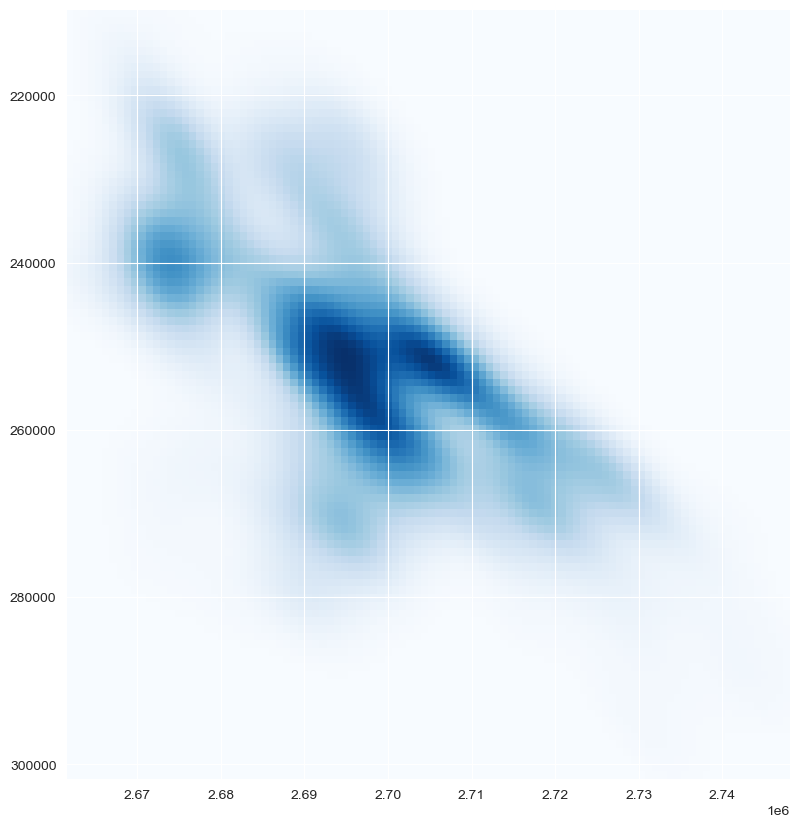

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))

extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
show(src, extent=extent, ax=ax, cmap='Blues')

In [117]:
import numpy as np
from scipy.stats import norm
from geopandas import GeoDataFrame

def silverman_bandwidth(data):
    """
    Calculates the fixed bandwidth using Silverman's rule of thumb.

    Parameters:
    -----------
    data : GeoDataFrame
        A geodataframe of points.

    Returns:
    --------
    float
        The fixed bandwidth.
    """

    # Get the number of dimensions (2 for longitude and latitude)
    num_dims = len(data.columns)

    # Get the number of data points
    num_points = len(data)

    # Calculate the standard deviation for each dimension
    std_dev = np.std(data, axis=0, ddof=1)

    # Calculate the mean of the standard deviation across all dimensions
    avg_std_dev = np.mean(std_dev)

    # Calculate the bandwidth using Silverman's rule of thumb
    bandwidth = (num_points * (avg_std_dev ** num_dims)) / (4 * (num_dims + 2))

    return bandwidth

In [118]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy import stats
import pandas as pd


def compute_adaptive_bandwidth(data, initial_bandwidth):
    """
    This function computes the adaptive bandwidth based on initial KDE.
    """
    # Step 1: Compute a KDE with a fixed bandwidth
    kde_skl = KernelDensity(bandwidth=initial_bandwidth)
    kde_skl.fit(data)

    # Step 2: Compute the densities
    density = np.exp(kde_skl.score_samples(data))

    # Step 3: Compute the adaptive bandwidth
    adaptive_bandwidth = initial_bandwidth * (1/density)**(0.5)

    return adaptive_bandwidth

In [123]:
def adaptive_kde_partition(data, initial_bandwidth, ngroups=None):
    """
    This function computes the KDE with adaptive bandwidth using partitioning.
    """
    # Step 1: Compute the adaptive bandwidth
    adaptive_bandwidth = compute_adaptive_bandwidth(data, initial_bandwidth)

    # Add small random noise to the bandwidth values
    adaptive_bandwidth += np.random.uniform(-0.01, 0.01, size=len(adaptive_bandwidth))

    # Step 2: Partition the data into groups
    if ngroups is None:
        ngroups = int(np.sqrt(len(data)))

    # Create a DataFrame for easier data manipulation
    df = pd.DataFrame(data, columns=['x', 'y'])
    df['bw'] = adaptive_bandwidth

    # Create the partitions
    df['group'] = pd.qcut(df['bw'], q=ngroups, labels=False)

    # Step 3: Compute the KDE for each group and store the density in the DataFrame
    for group in df['group'].unique():
        group_data = df[df['group'] == group][['x', 'y']]
        group_bw = df[df['group'] == group]['bw'].mean()

        kde_skl = KernelDensity(bandwidth=group_bw)
        kde_skl.fit(group_data)

        df.loc[df['group'] == group, 'density'] = np.exp(kde_skl.score_samples(group_data))

    return df


In [124]:
# Extract x and y coordinates from the geometry column
guncrime_gdf['x'] = guncrime_gdf.geometry.x
guncrime_gdf['y'] = guncrime_gdf.geometry.y

# Select only the x and y columns
guncrime_coords = guncrime_gdf[['x', 'y']].values

input_bandwidth = silverman_bandwidth(guncrime_gdf)

# Use these coordinates as input to the function
guncrime_kde = adaptive_kde_partition(guncrime_coords, 0.1)

C:\Users\Nissim\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3571: FutureWarning: The default value of numeric_only in GeoDataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [125]:
guncrime_kde.head()

,x,y,bw,group,density
0,2.701500e+06,254527.321168,1.384498,30,0.002103
1,2.687641e+06,228770.117892,1.952981,70,0.000535
2,2.713881e+06,277084.476991,1.938632,38,0.000536
3,2.693642e+06,272700.071299,1.951537,67,0.000536
4,2.686796e+06,250843.723880,1.125394,11,0.001592


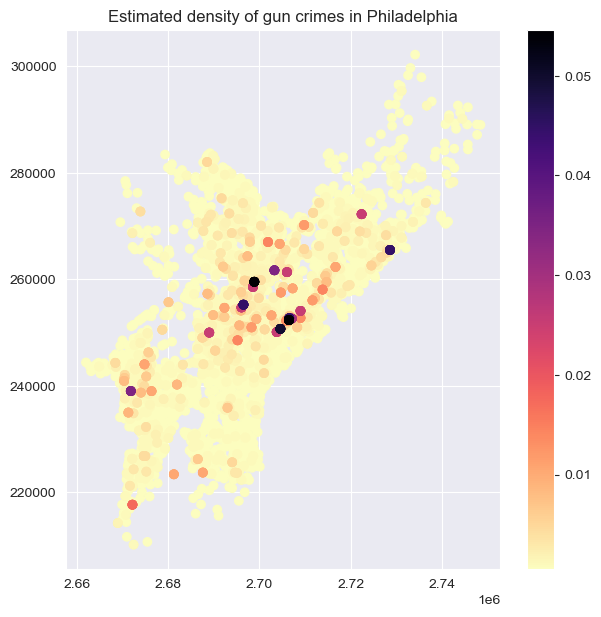

In [126]:
# sort guncrime_kde by descending density
guncrime_kde = guncrime_kde.sort_values(by='density', ascending=True)

# plot guncrime_kde with points colored by 'density'
plt.figure(figsize=(7,7))
plt.scatter(guncrime_kde['x'], guncrime_kde['y'], c=guncrime_kde['density'], cmap='magma_r')
plt.colorbar()
plt.title('Estimated density of gun crimes in Philadelphia')
plt.show()

In [82]:
# Modify the SQL query
drug_crime_sql_query = "SELECT text_general_code, dispatch_date, point_x, point_y FROM incidents_part1_part2 WHERE dispatch_date_time >= '{}' AND text_general_code IN ('Narcotic / Drug Law Violations')".format(one_year_ago)

# Make the GET request
drug_crime_response = requests.get("https://phl.carto.com/api/v2/sql", params={"q": drug_crime_sql_query})

# Get the data
drug_crime_data = drug_crime_response.json()["rows"]

# convert drug_crime_data to a pandas dataframe
drug_crime_df = pd.DataFrame(drug_crime_data)

# drop null geometry values
drug_crime_df = drug_crime_df[drug_crime_df['point_x'].notnull()]
drug_crime_df = drug_crime_df[drug_crime_df['point_y'].notnull()]

# Convert the data to a geopandas dataframe
drug_crime_gdf = gpd.GeoDataFrame(drug_crime_df, geometry=gpd.points_from_xy(drug_crime_df.point_x, drug_crime_df.point_y), crs='EPSG:4326')

# drop the lat and lon columns
drug_crime_gdf.drop(['point_x', 'point_y'], axis=1, inplace=True)

# convert the geometry column to a CRS 2272
drug_crime_gdf.to_crs(epsg=2272, inplace=True)

In [83]:
# Extract x and y coordinates from the geometry column
drug_crime_gdf['x'] = drug_crime_gdf.geometry.x
drug_crime_gdf['y'] = drug_crime_gdf.geometry.y

# Select only the x and y columns
drug_crime_coords = drug_crime_gdf[['x', 'y']].values

# Use these coordinates as input to the function
drug_crime_kde = adaptive_kde_partition(drug_crime_coords, 0.1)

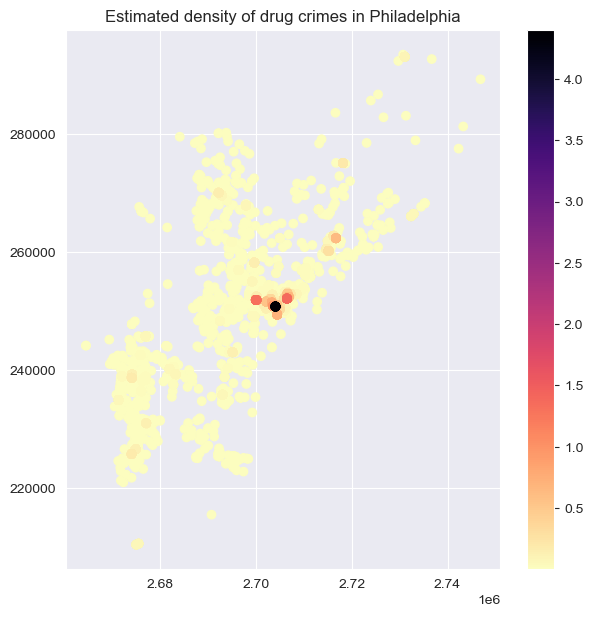

In [84]:
# sort drug_crime_kde by descending density
drug_crime_kde = drug_crime_kde.sort_values(by='density', ascending=True)

# plot drug_crime_kde with points colored by 'density'
plt.figure(figsize=(7,7))
plt.scatter(drug_crime_kde['x'], drug_crime_kde['y'], c=drug_crime_kde['density'], cmap='magma_r')
plt.colorbar()
plt.title('Estimated density of drug crimes in Philadelphia')
plt.show()

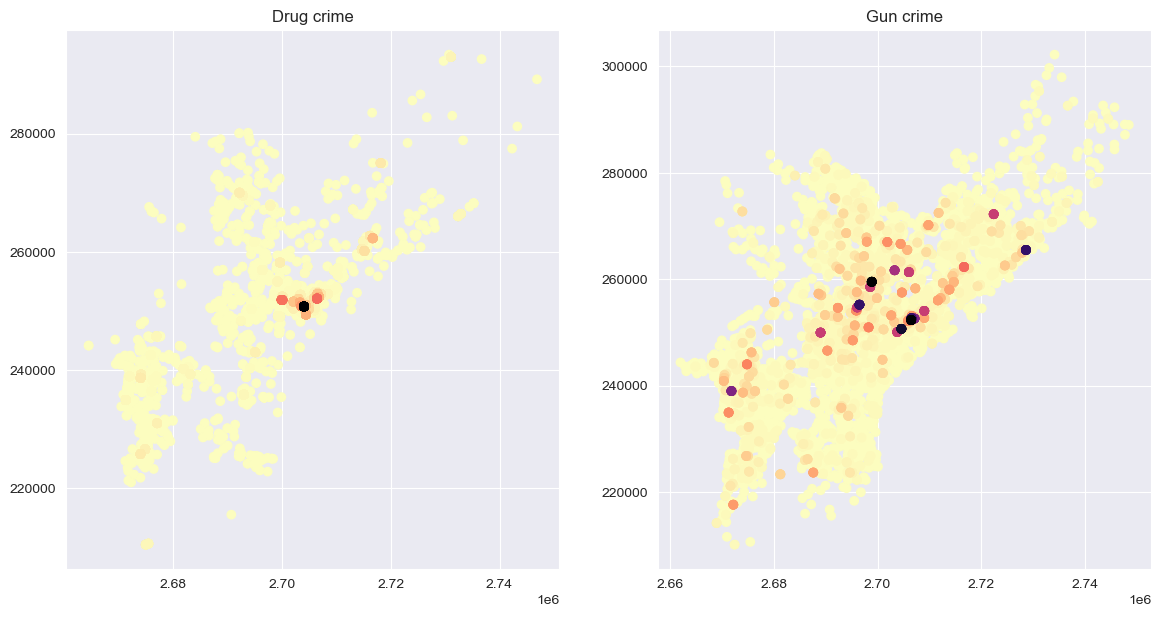

In [85]:
# plot drug crime and gun crime side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,7))

# plot drug crime
ax1.scatter(drug_crime_kde['x'], drug_crime_kde['y'], c=drug_crime_kde['density'], cmap='magma_r')
ax1.set_title('Drug crime')

# plot gun crime
ax2.scatter(guncrime_kde['x'], guncrime_kde['y'], c=guncrime_kde['density'], cmap='magma_r')
ax2.set_title('Gun crime')

plt.show()

In [91]:
top_list = ['Top ' + str(i) + '%' for i in range(1, 51)]
bottom_list = ['Bottom ' + str(i) + '%' for i in range(1, 51)]
result_list = top_list + bottom_list[::-1]

In [92]:
print(result_list)

['Top 1%', 'Top 2%', 'Top 3%', 'Top 4%', 'Top 5%', 'Top 6%', 'Top 7%', 'Top 8%', 'Top 9%', 'Top 10%', 'Top 11%', 'Top 12%', 'Top 13%', 'Top 14%', 'Top 15%', 'Top 16%', 'Top 17%', 'Top 18%', 'Top 19%', 'Top 20%', 'Top 21%', 'Top 22%', 'Top 23%', 'Top 24%', 'Top 25%', 'Top 26%', 'Top 27%', 'Top 28%', 'Top 29%', 'Top 30%', 'Top 31%', 'Top 32%', 'Top 33%', 'Top 34%', 'Top 35%', 'Top 36%', 'Top 37%', 'Top 38%', 'Top 39%', 'Top 40%', 'Top 41%', 'Top 42%', 'Top 43%', 'Top 44%', 'Top 45%', 'Top 46%', 'Top 47%', 'Top 48%', 'Top 49%', 'Top 50%', 'Bottom 50%', 'Bottom 49%', 'Bottom 48%', 'Bottom 47%', 'Bottom 46%', 'Bottom 45%', 'Bottom 44%', 'Bottom 43%', 'Bottom 42%', 'Bottom 41%', 'Bottom 40%', 'Bottom 39%', 'Bottom 38%', 'Bottom 37%', 'Bottom 36%', 'Bottom 35%', 'Bottom 34%', 'Bottom 33%', 'Bottom 32%', 'Bottom 31%', 'Bottom 30%', 'Bottom 29%', 'Bottom 28%', 'Bottom 27%', 'Bottom 26%', 'Bottom 25%', 'Bottom 24%', 'Bottom 23%', 'Bottom 22%', 'Bottom 21%', 'Bottom 20%', 'Bottom 19%', 'Bottom 18

In [93]:
pct_list = list(range(100, 0, -1))

In [94]:
import mapclassify

guncrime_classifier = mapclassify.Percentiles(guncrime_kde['density'], pct=pct_list)

guncrime_kde['density'] = guncrime_kde[['density']].apply(guncrime_classifier)

In [95]:
# return five random rows from the dataframe
guncrime_kde.sample(5)

,x,y,bw,group,density
2118,2.714742e+06,263730.405870,1.941633,45,46
561,2.699362e+06,272496.744463,1.937632,36,55
4999,2.705916e+06,252326.283741,0.866887,3,96
4226,2.697516e+06,247628.372589,1.380407,26,61
330,2.697401e+06,261915.155822,1.949667,62,29


In [97]:
guncrime_kde['density'] = guncrime_kde['density'].replace(pct_list, result_list)

In [100]:
guncrime_kde.sample(5)

,x,y,bw,group,density
2135,2.671606e+06,237615.769047,1.950995,65,Bottom 6%
1942,2.728630e+06,265516.421910,0.645804,0,Top 2%
5306,2.687866e+06,248963.183811,1.376697,23,Top 37%
2754,2.691857e+06,252444.582518,1.944810,52,Bottom 40%
325,2.686338e+06,251756.705104,1.366232,14,Top 20%


In [101]:
drug_crime_classifier = mapclassify.Percentiles(drug_crime_kde['density'], pct=pct_list)

drug_crime_kde['density'] = drug_crime_kde[['density']].apply(drug_crime_classifier)

drug_crime_kde['density'] = drug_crime_kde['density'].replace(pct_list, result_list)

drug_crime_kde.sample(5)

,x,y,bw,group,density
1100,2.694376e+06,250357.028109,0.595042,24,Bottom 47%
2051,2.678081e+06,239902.753119,1.310891,41,Top 20%
1870,2.697861e+06,267853.531335,0.487681,18,Bottom 30%
649,2.688854e+06,267352.417543,1.323748,50,Top 2%
1785,2.703784e+06,250085.251595,1.323828,50,Top 2%


In [103]:
guncrime_bandwidth = silverman_bandwidth(guncrime_kde)

C:\Users\Nissim\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3571: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [104]:
print(guncrime_bandwidth)

5.121459194763339e+21
